# Bonus: ParmEst for Four State Model

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TCLabExperiment,
    create_model,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 4

In this notebook, we will consider a four-state TCLab model that considers both heater/sensor channels:

$$
\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{H,2}-T_{H,1}) + U_c(T_{S,1} - T_{H,1}) + P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_c(T_{H,1} - T_{S,1})  \\
C^H_p\frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{H,1}-T_{H,2}) + U_c(T_{S,2} - T_{H,2}) + P_2u_2\\
C^S_p\frac{dT_{S,2}}{dt} & = U_c(T_{H,2} - T_{S,2}) 
\end{align}
$$

Our goal is to regress $U_a$, $U_b$, $U_c$, $C_p^H$, and $C_p^S$. In this model, we assume both heater/sensor channels are identical, i.e., they share model parameters.

## Load and explore experimental data

In [2]:
import pandas as pd

file = '../data/tclab_sine_test.csv'
# file = './data/tclab_step_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


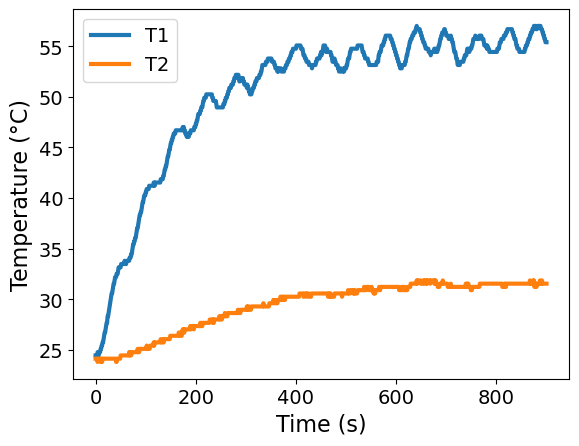

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

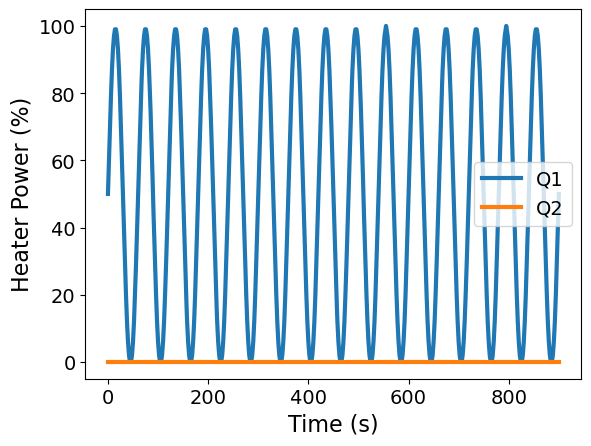

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

## Store in Custom Data Class 

In [5]:
tc_data = TCLabExperiment(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

In [6]:
tc_data.to_data_frame().head()

,time,T1,u1,P1,TS1_data,T2,u2,P2,TS2_data,Tamb
0,0.00,24.45,50.0,200,None,24.13,0.0,200,None,24.45
1,1.00,24.45,55.0,200,None,24.13,0.0,200,None,24.45
2,2.01,24.45,60.0,200,None,24.13,0.0,200,None,24.45
3,3.01,24.45,65.0,200,None,24.13,0.0,200,None,24.45
4,4.01,24.77,70.0,200,None,23.81,0.0,200,None,24.45


## Parameter Estimation with ParmEst

In [7]:
import pyomo.contrib.parmest.parmest as parmest

# define the parameter names as a list
# theta_names = ['Ua', 'Ub', 'inv_CpH', 'inv_CpS']
theta_names = ['Ua', 'Ub', 'Uc', 'inv_CpH', 'inv_CpS']

parmest_create_model = lambda data: create_model(
    data=data, 
    mode='parmest', 
    number_of_states=4
)

# Create a parameter estimation object
pest = parmest.Estimator(
    parmest_create_model,
    data=[
        tc_data.to_data_frame()
    ],  # Needs to be a list of dataframes, otherwise parmest threats each row as a separate model
    theta_names=theta_names,
    tee=True,
)

obj, theta = pest.theta_est()

(model_function, data, theta_names). This interface will be removed in a
future release, please update to the new parmest interface using experiment
lists.  (deprecated in 6.7.2) (called from
/Users/adowling/anaconda3/envs/summer2024/lib/python3.10/functools.py:926)
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific c

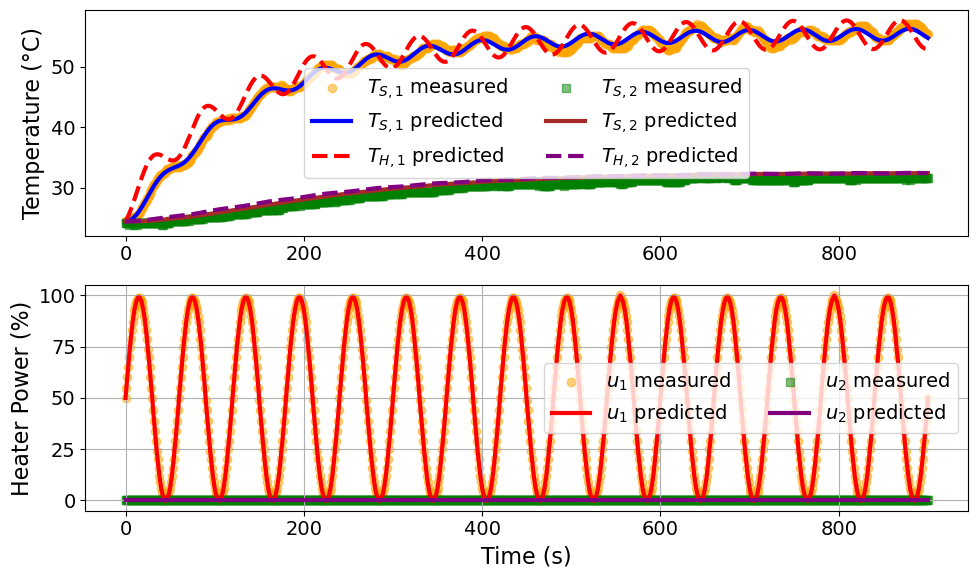

Model parameters:
Ua = 0.0406 Watts/degC
Ub = 0.0005 Watts/degC
Uc = 0.0143 Watts/degC
CpH = 6.3919 Joules/degC
CpS = 0.01 Joules/degC
 


In [8]:
parmest_regression_results = extract_plot_results(tc_data, pest.pest_deprecated.parmest_model)

In [9]:
theta_values = theta.to_dict()
print("Estimated parameters:\n", theta_values)

Estimated parameters:
 {'Ua': 0.0406328703006202, 'Ub': 0.0004788908684868069, 'Uc': 0.014287092203588921, 'inv_CpH': 0.15644842098642808, 'inv_CpS': 99.99999924789579}
